Output of evaluation of different thresholds on synthetic data suggests that lower thresholds are always better. Is there a bug in the response model? Let's find out by reproducing the epoching analysis here with scipy.

In [53]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
from tqdm.notebook import tqdm

import torch

In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd()))

from berp.generators import thresholded_recognition
from berp.models.reindexing_regression import ModelParameters

In [56]:
X_word = pd.read_csv("X_word.csv")
X_word["cum_token_idx"] = X_word.index

X_phon = pd.read_csv("X_phon.csv")
X_phon = pd.merge(X_phon, X_word[["item", "token_idx", "cum_token_idx"]],
                  left_on=["item", "token_idx"], right_on=["item", "token_idx"])

y = pd.read_csv("y.csv")

onsets = pd.read_csv("onsets.csv")
onsets.columns=["threshold", "cum_token_idx", "onset"]
# `onsets` is relative to word onset. make this absolute
onsets = pd.merge(onsets, X_phon[X_phon.phon_idx == 0].rename(columns={"time": "t0"})[["t0", "cum_token_idx"]],
                  left_on="cum_token_idx", right_on="cum_token_idx", how="outer")
onsets["onset"] += onsets.t0

In [57]:
X_word

,item,token_idx,token,time,recognition_point,surprisal,cum_token_idx
0,0,0,ice,0.093750,0,12.528906,0
1,0,1,was,0.593750,0,6.968839,1
2,0,2,beginning,1.312500,5,12.062911,2
3,0,3,to,1.789062,0,0.133897,3
4,0,4,get,2.148438,0,5.561836,4
...,...,...,...,...,...,...,...
151,9,14,it,5.953125,0,3.732605,151
152,9,15,was,6.195312,0,1.278864,152
153,9,16,too,6.671875,0,2.200048,153
154,9,17,dark,6.992188,0,6.274787,154


In [58]:
onsets

,threshold,cum_token_idx,onset,t0
0,0.700000,0,0.359375,0.09375
1,0.168690,0,0.359375,0.09375
2,0.886670,0,0.359375,0.09375
3,0.100193,0,0.359375,0.09375
4,0.953431,0,0.359375,0.09375
...,...,...,...,...
1711,0.888328,155,7.640625,7.53125
1712,0.713362,155,7.640625,7.53125
1713,0.723374,155,7.640625,7.53125
1714,0.823866,155,7.640625,7.53125


43 tokens (27.564102564102566%) have no change in onset for threshold options


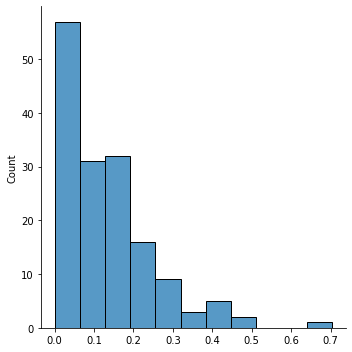

In [59]:
# Visualize range in inferred word recognition onset as a function of threshold
onset_ranges = onsets.groupby("cum_token_idx").apply(lambda rows: rows.onset.max() - rows.onset.min())

n_unchanged = (onset_ranges == 0).sum()
print(f"{n_unchanged} tokens ({n_unchanged / len(onset_ranges) * 100}%) have no change in onset for threshold options")
sns.displot(onset_ranges)

In [60]:
all_df = {}

for threshold, t_onsets in tqdm(onsets.groupby("threshold")):
    X_word_new = X_word.copy()
    X_word_new["time_gt"] = X_word.time
    
    X_word_new["time"] = t_onsets.reset_index().onset
    X_word_new = X_word_new.set_index(["item", "token_idx"])
    
    # print(threshold, (X_word_new.time - X_word_new.time_gt).abs().mean())
    
    epochs = thresholded_recognition.dataset_to_epochs(X_word_new, y.set_index("item"))
    
    baseline_window = (-.1, 0)
    test_window = (0.3, 0.5)
    df_test = epochs.groupby(["item", "token_idx"]).apply(
        lambda rows: pd.Series({"epoch_baseline": rows[(rows.epoch_time >= baseline_window[0]) & (rows.epoch_time < baseline_window[1])].signal.mean(),
                                "epoch_value": rows[(rows.epoch_time >= test_window[0]) & (rows.epoch_time < test_window[1])].signal.mean()}))
    
    all_df[threshold] = pd.merge(df_test, X_word_new, left_index=True, right_index=True)
    
all_df = pd.concat(all_df, names=["threshold", "item", "token_idx"])
all_df["epoch_value_baselined"] = all_df.epoch_value - all_df.epoch_baseline

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

In [61]:
all_df

epoch_baseline  epoch_value      token      time  \
threshold item token_idx                                                     
0.032262  0    0              -18.382931   -47.155697        ice  0.359375   
               1              -43.309267   -62.989584        was  0.695312   
               2              -88.698300   -98.798958  beginning  1.445312   
               3             -106.591186   -47.895086         to  1.835938   
               4              -56.023957   -44.373162        get  2.195312   
...                                  ...          ...        ...       ...   
0.953431  9    14             -53.045455   -40.627701         it  6.062500   
               15             -43.418209   -25.962829        was  6.429688   
               16             -25.455796   -36.710147        too  6.921875   
               17             -34.717306   -37.638860       dark  7.335938   
               18             -40.085527   -24.458852         to  7.640625   

                          recognition_point  surprisal  cum_token_idx  \
threshold item token_idx                                                
0.032262  0    0                          0  12.528906              0   
               1                          0   6.968839              1   
               2                          5  12.062911              2   
               3                          0   0.133897              3   
               4                          0   5.561836              4   
...                                     ...        ...            ...   
0.953431  9    14                         0   3.732605            151   
               15                         0   1.278864            152   
               16                         0   2.200048            153   
               17                         0   6.274787            154   
               18                         0   2.934767            155   

                           time_gt  epoch_value_baselined  
threshold item token_idx                                   
0.032262  0    0          0.093750             -28.772766  
               1          0.593750             -19.680318  
               2          1.312500             -10.100659  
               3          1.789062              58.696100  
               4          2.148438              11.650795  
...                            ...                    ...  
0.953431  9    14         5.953125              12.417754  
               15         6.195312              17.455380  
               16         6.671875             -11.254351  
               17         6.992188              -2.921554  
               18         7.531250              15.626675  

[1716 rows x 9 columns]

In [62]:
lr_results = {}
for threshold, dataset in tqdm(all_df.groupby("threshold")):
    X = -1 * dataset.surprisal.values # [:, np.newaxis]
    y = dataset.epoch_value_baselined.values
    lr_results[threshold] = st.linregress(X, y)
    
lr_results = pd.DataFrame(lr_results).T.rename(columns=dict(enumerate(["slope", "intercept", "rvalue", "pvalue", "stderr", "intercept_stderr"])))
lr_results.index.name = "threshold"
lr_results

  0%|          | 0/11 [00:00<?, ?it/s]

,slope,intercept,rvalue,pvalue,stderr
threshold,,,,,
0.032262,2.477656,19.726561,0.479355,2.439067e-10,0.365536
0.100193,2.221912,19.544137,0.449635,3.901942e-09,0.355682
0.157390,2.177048,19.700523,0.452892,2.916613e-09,0.345355
0.168690,2.166548,19.514716,0.450011,3.773489e-09,0.346455
0.700000,1.903819,16.865334,0.403890,1.708858e-07,0.347481
0.713362,1.881710,16.638355,0.400257,2.253801e-07,0.347168
0.723374,1.867273,16.494816,0.396723,2.940632e-07,0.348155
0.823866,1.836355,16.181093,0.389523,5.009157e-07,0.349889
0.886670,1.734863,15.194016,0.370356,1.946754e-06,0.350631


<AxesSubplot:xlabel='threshold', ylabel='rvalue'>

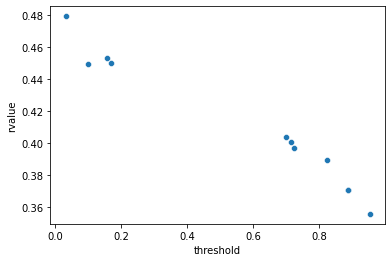

In [63]:
sns.scatterplot(data=lr_results.reset_index(), x="threshold", y="rvalue")